# GIS routing

All the algorithms presented so far are almost what you are going to need if you want to create your routing system and the big names in the field like Google and Apple and Microsoft are using modified versions of these algorithms because they have a lot of data and huge infrastructure so they could tune their heuristic to give impressive preformance.  


There is a highly-cited survey on all of these methods and more and how they are used in the industry at [Route Planning in Transportation Networks](https://arxiv.org/pdf/1504.05140.pdf). The authors of that survey are pretty much the creators of that field and most of these algorithms, so stalking them will really help you in this course.

---

We decided to make this notebook to only show you animation of the algorithms and the trend of expansion for each one. We didn't provide the animation in the algorithms notebooks because we didn't want to smear the code with animations utilities and here you can scroll up and down and see the difference in the same notebook and we would also use a bigger map.

---

As we are animating the algorithm on a big graph with >1000 nodes and loops and not straight edges, you won't be able to trace the algorithm iterations but our hope is that you see the overall pattern of expansion for all the nodes.

# Getting the map

In [1]:
import osmnx as ox
import time
from tqdm import tqdm
from collections import deque
from IPython.display import HTML
from utilities import *

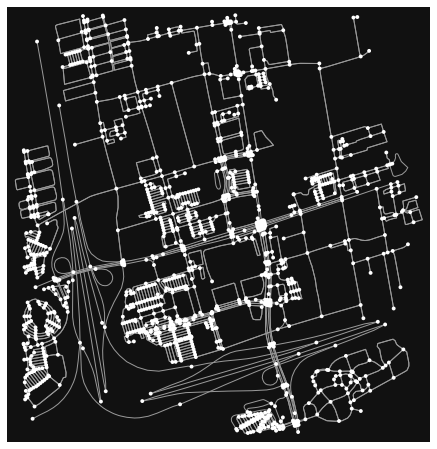

In [2]:
G = ox.graph_from_address('vaughan', dist= 1400)
fig, ax = ox.plot_graph(G)

let's find two arbitrary vertices to be our source and destination

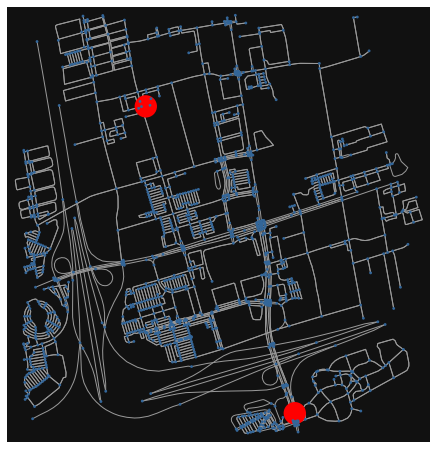

In [3]:
highlighted = [29658954, 7450058649]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [500 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

Let's make our usual set up

In [4]:
origin = Node(graph = G, osmid = 29658954)
destination = Node(graph = G, osmid = 7450058649)

### Breadth First Search
please note `colors` array which serves as stamp for the current state of the traversing and expansion of the nodes, otherwise it is the same algorithm.

In [ ]:
%%time
bar = tqdm(total=len(G))
colors = []

route = []
frontier = deque([origin])
explored = set()

found = False

while frontier and not found:
    bar.update(1); # time.sleep(0.05) # for the progress bar -- ignore
    node = frontier.popleft()
    explored.add(node)
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                
                state_color = [1 if node in route else 6 for node in G.nodes()]
                colors.extend([*[*([state_color]*50)]]) # all that packing/unpacking to extend the period
                                                        # in the video 
                
            frontier.append(child)

    state_color = [1 if node in explored else 6 for node in G.nodes()]
    colors.append(state_color)
    
bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

In [ ]:
draw_route(G, route)

Focus on how breadth first search traverse on the graph and how it expands on all directions and waste time

In [ ]:
%%capture
# to speed up the video you decrease the variable speed not increase it
ani = animate_simple(G, colors, speed = 100)

In [ ]:
# this would take some time (2-3 mins) to be rendered
HTML(ani.to_html5_video())

### Depth First Search

In [ ]:
%%time
bar = tqdm(total=len(G))
colors = []

route = []
frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    bar.update(1); # time.sleep(0.05)
    node = frontier.pop()
    explored.add(node)
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route  = child.path()
                found = True
                
                state_color = [1 if node in route else 6 for node in G.nodes()]
                colors.extend([*[*([state_color]*50)]])
                
                continue
            frontier.append(child)
    state_color = [1 if node in explored else 6 for node in G.nodes()]
    colors.append(state_color)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

In [ ]:
draw_route(G, route)

In [ ]:
%%capture
ani = animate_simple(G, colors, speed = 100)

In [ ]:
# this would take some time (2-3 mins) to be rendered
HTML(ani.to_html5_video())

## A star search

In [ ]:
toGoal, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)

In [ ]:
%%time
route = []
frontier = list()

bar = tqdm(total=len(G)) # for the progress bar
colors = []

frontier.append(origin)
explored = set()
found = False

while frontier and not found:
    bar.update(1);# time.sleep(0.05)
    
    # choose a node based on its heuristic value
    node = min(frontier, key = lambda node : toGoal[node.osmid] + toDestination[node.osmid])
    frontier.remove(node)
    explored.add(node)
    
    # expand its children
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                
                state_color = [1 if node in route else 6 for node in G.nodes()]
                colors.extend([*[*([state_color]*50)]])
                
                continue
            frontier.append(child)
    
    state_color = [1 if node in explored else 6 for node in G.nodes()]
    colors.append(state_color)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

In [ ]:
draw_route(G, route)

In [ ]:
%%capture
ani = animate_simple(G, colors, speed = 100)

In [ ]:
# this would take some time (2-3 mins) to be rendered
HTML(ani.to_html5_video())

## Dijkstra Search

In [ ]:
%%time
bar = tqdm(total = len(G))

colors = []

seen = set()         # for dealing with self loops

shortest_dist = {osmid: math.inf for osmid in G.nodes()}
unrelaxed_nodes = [Node(graph = G, osmid = osmid) for osmid in G.nodes()]

shortest_dist[origin.osmid] = 0
found = False

while len(unrelaxed_nodes) > 0 and not found:
    bar.update(1); # time.sleep(0.05)
    
    node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node.osmid])
    
    unrelaxed_nodes.remove(node)
    seen.add(node.osmid)
        
    if node == destination:
        route = node.path()
        cost = shortest_dist[node.osmid]
        found = True
        
        state_color = [1 if node in route else 6 for node in G.nodes()]
        colors.extend([*[*([state_color]*50)]])
        
        continue

    for child in node.expand():

        if child.osmid in seen: continue
        
        child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
        child_obj.distance = child.distance
        
        distance = shortest_dist[node.osmid] + child.distance
        if distance < shortest_dist[child_obj.osmid]:
            shortest_dist[child_obj.osmid] = distance
            child_obj.parent = node
    
    state_color = [1 if node in seen else 6 for node in G.nodes()]
    colors.append(state_color)
bar.close()
print(f"The route is \n\n{route} \n\nits cost is\n\n{cost}")

In [ ]:
draw_route(G, route)

In [ ]:
%%capture
ani = animate_simple(G, colors, speed = 100)

In [ ]:
HTML(ani.to_html5_video())